In [1]:
# Install openpyxl if not installed
!pip install openpyxl --quiet

# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX



In [2]:

# Load the Excel file using the correct sheet name
file_path = "/content/sample_data/Data_Airline_to_Py.xlsx"
df = pd.read_excel(file_path, sheet_name="Demandeq")

# Clean column names
df.columns = df.columns.str.strip()

# Convert 'Date' column to datetime
df['DateYM'] = pd.to_datetime(df['DateYM'])

# Set 'Date' as the index
df.set_index('DateYM', inplace=True)

# Display first few rows
df.head()


,Rpks,GDP,Yield,Dumy Vacations
DateYM,,,,
2015-01-01,13774656,1911198,0.111949,0
2015-02-01,12918782,1909731,0.114012,0
2015-03-01,14960327,1907789,0.113736,1
2015-04-01,13548366,1906000,0.111598,0
2015-05-01,13642565,1902034,0.112339,0


In [3]:
# Define the dependent and independent variables
X = df[['GDP', 'Yield', 'Dumy Vacations']]
y = df['Rpks']

# Add a constant to the independent variables matrix
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Display the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Rpks   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     38.97
Date:                Wed, 18 Jun 2025   Prob (F-statistic):           1.29e-17
Time:                        22:46:00   Log-Likelihood:                -2056.0
No. Observations:                 123   AIC:                             4120.
Df Residuals:                     119   BIC:                             4131.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.571e+06   6.85e+06      0.

In [4]:
# Apply logarithmic transformation
df_log = df[['Rpks', 'GDP', 'Yield', 'Dumy Vacations']].copy()
df_log['log_Rpks'] = np.log(df_log['Rpks'])
df_log['log_GDP'] = np.log(df_log['GDP'])
df_log['log_Yield'] = np.log(df_log['Yield'])

# Define independent and dependent variables for log model
X_log = df_log[['log_GDP', 'log_Yield', 'Dumy Vacations']]
X_log = sm.add_constant(X_log)
y_log = df_log['log_Rpks']

# Run the logged regression
model_log = sm.OLS(y_log, X_log).fit()

# Display the logged regression summary
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:               log_Rpks   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     239.2
Date:                Wed, 18 Jun 2025   Prob (F-statistic):           3.29e-50
Time:                        22:46:02   Log-Likelihood:                -41.759
No. Observations:                 123   AIC:                             91.52
Df Residuals:                     119   BIC:                             102.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -43.2023      7.415     -5.

In [5]:
# 1. Durbin-Watson test for autocorrelation
dw_stat = durbin_watson(model_log.resid)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X_log.columns
vif_data['VIF'] = [variance_inflation_factor(X_log.values, i) for i in range(X_log.shape[1])]

# Round VIF values to 2 decimals
vif_data['VIF'] = vif_data['VIF'].round(2)

# Optional: remove 'const' row from VIF table
vif_data = vif_data[vif_data['feature'] != 'const'].reset_index(drop=True)

# Display results
print(f"Durbin-Watson Statistic: {round(dw_stat, 2)}")
vif_data


Durbin-Watson Statistic: 0.55


,feature,VIF
0,log_GDP,1.0
1,log_Yield,1.0
2,Dumy Vacations,1.0


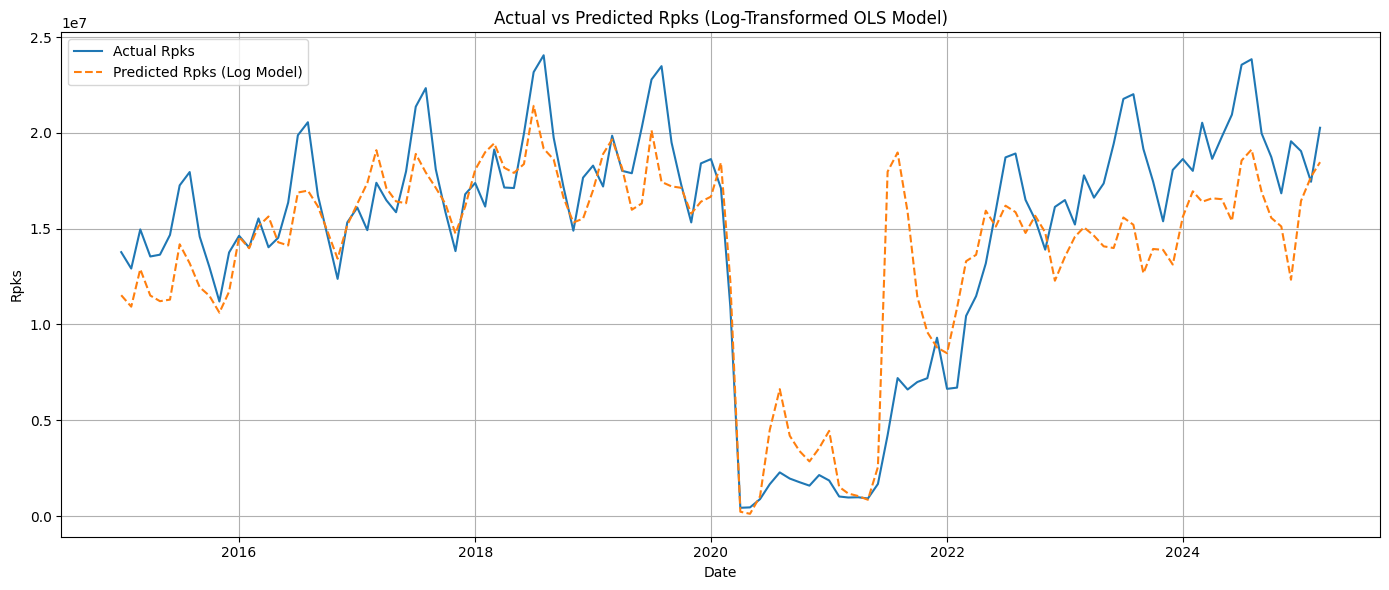

In [6]:
# Make predictions in log scale and convert to original scale
df['Predicted_log_Rpks'] = model_log.predict(X_log)
df['Predicted_Rpks'] = np.exp(df['Predicted_log_Rpks'])


# Plot actual vs predicted RPKs with date on x-axis
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Rpks'], label='Actual Rpks')
plt.plot(df.index, df['Predicted_Rpks'], label='Predicted Rpks (Log Model)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Rpks')
plt.title('Actual vs Predicted Rpks (Log-Transformed OLS Model)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


--- ADF Test on log_Rpks ---
ADF Statistic: -2.6980
p-value: 0.0744
Critical Values:
   1%: -3.4856
   5%: -2.8857
   10%: -2.5797
------------------------------
--- ADF Test on Differenced log_Rpks ---
ADF Statistic: -8.2272
p-value: 0.0000
Critical Values:
   1%: -3.4861
   5%: -2.8859
   10%: -2.5798
------------------------------


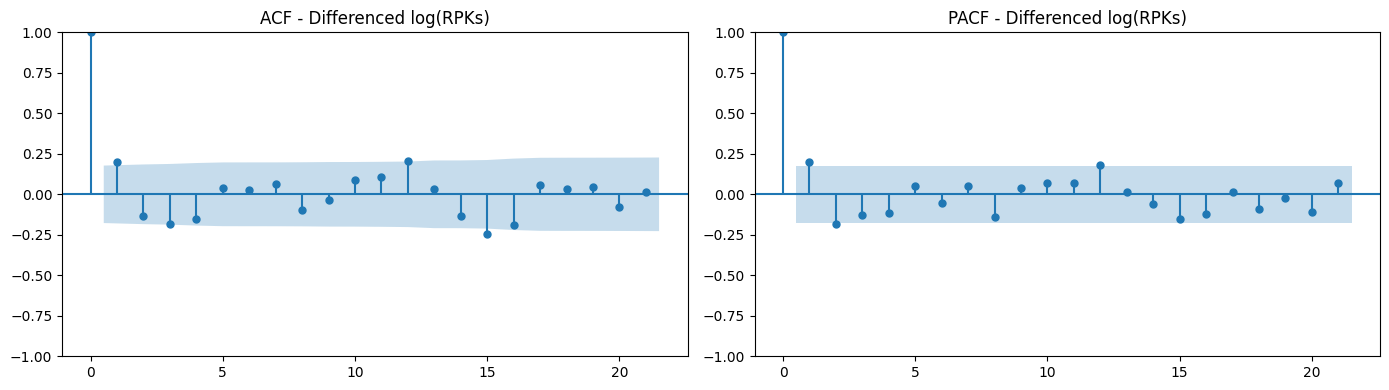

In [7]:
# Log-transform the RPKs for better ARIMA modeling
df['log_Rpks'] = np.log(df['Rpks'])

# ADF Test for stationarity
adf_result = adfuller(df['log_Rpks'])

# Differencing the series if needed
df['log_Rpks_diff'] = df['log_Rpks'].diff().dropna()

# ADF test on differenced data
adf_diff_result = adfuller(df['log_Rpks_diff'].dropna())

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(df['log_Rpks_diff'].dropna(), ax=axes[0])
plot_pacf(df['log_Rpks_diff'].dropna(), ax=axes[1])
axes[0].set_title('ACF - Differenced log(RPKs)')
axes[1].set_title('PACF - Differenced log(RPKs)')
plt.tight_layout()

# Function to format and display ADF test results
def print_adf_results(name, result):
    print(f"--- ADF Test on {name} ---")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    print("-" * 30)

# Display results nicely
print_adf_results("log_Rpks", adf_result)
print_adf_results("Differenced log_Rpks", adf_diff_result)


In [19]:
# Fit ARIMA(1,1,1) model on log-transformed RPKs
model_arima = ARIMA(df['log_Rpks'], order=(2, 1, 1))
results_arima = model_arima.fit()

# Display summary
print(results_arima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               log_Rpks   No. Observations:                  123
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -40.674
Date:                Wed, 18 Jun 2025   AIC                             89.349
Time:                        23:17:35   BIC                            100.565
Sample:                    01-01-2015   HQIC                            93.905
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7771      0.507      1.533      0.125      -0.217       1.771
ar.L2         -0.2986      0.198     -1.505      0.132      -0.688       0.090
ma.L1         -0.5728      0.526     -1.089      0.2

In [ ]:
df['log_GDP'] = np.log(df['GDP'])
df['log_Yield'] = np.log(df['Yield'])

# Fit SARIMAX model with GDP and Yield as exogenous regressors
model_sarimax = SARIMAX(df['log_Rpks'],
                        order=(2, 1, 1),
                        exog=df[['log_GDP', 'log_Yield']],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

results_sarimax = model_sarimax.fit()

# Display summary
print(results_sarimax.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               log_Rpks   No. Observations:                  123
Model:               SARIMAX(2, 1, 1)   Log Likelihood                  33.460
Date:                Mon, 16 Jun 2025   AIC                            -54.921
Time:                        16:58:17   BIC                            -38.196
Sample:                    01-01-2015   HQIC                           -48.129
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_GDP        8.6246      1.308      6.595      0.000       6.061      11.188
log_Yield     -1.2625      0.133     -9.497      0.000      -1.523      -1.002
ar.L1         -1.0615      0.178     -5.967      0.0

In [18]:
df['log_GDP'] = np.log(df['GDP'])
df['log_Yield'] = np.log(df['Yield'])

# Fit SARIMAX model with GDP and Yield as exogenous regressors
model_sarimax = SARIMAX(df['log_Rpks'],
                        order=(2, 1, 1),
                        exog=df[['log_GDP', 'log_Yield', 'Dumy Vacations']],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

results_sarimax = model_sarimax.fit(method='powell', disp=True)

# Display summary
print(results_sarimax.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -0.601617
         Iterations: 3
         Function evaluations: 212
                               SARIMAX Results                                
Dep. Variable:               log_Rpks   No. Observations:                  123
Model:               SARIMAX(2, 1, 1)   Log Likelihood                  73.999
Date:                Wed, 18 Jun 2025   AIC                           -133.998
Time:                        23:02:02   BIC                           -114.485
Sample:                    01-01-2015   HQIC                          -126.074
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
log_GDP            9.1942      0.997      9.218      0.000     

In [ ]:
# Step 1: Create log-transformed variables if not done yet
df['log_GDP'] = np.log(df['GDP'])
df['log_Yield'] = np.log(df['Yield'])

# Step 2: Define log-transformed exogenous variables
exog_base_log = df[['log_GDP', 'log_Yield']]
exog_full_log = df[['log_GDP', 'log_Yield', 'Dumy Vacations']]

# Step 3: Fit SARIMAX(2,1,1) on log_Rpks without Dummy
model_base_log = SARIMAX(df['log_Rpks'], order=(2, 1, 1), exog=exog_base_log)
results_base_log = model_base_log.fit(disp=False)

# Step 4: Fit SARIMAX(2,1,1) on log_Rpks with Dummy
model_full_log = SARIMAX(df['log_Rpks'], order=(2, 1, 1), exog=exog_full_log)
results_full_log = model_full_log.fit(disp=False)

# Step 5: Build and print comparison table
comparison_log = {
    "Model": ["SARIMAX log w/o Dummy", "SARIMAX log w/ Dummy"],
    "AIC": [results_base_log.aic, results_full_log.aic],
    "BIC": [results_base_log.bic, results_full_log.bic],
    "Log-Likelihood": [results_base_log.llf, results_full_log.llf]
}

comparison_log_df = pd.DataFrame(comparison_log)
print(comparison_log_df)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                   Model         AIC         BIC  Log-Likelihood
0  SARIMAX log w/o Dummy  -55.942077  -39.117950       33.971038
1   SARIMAX log w/ Dummy -138.397666 -118.769519       76.198833


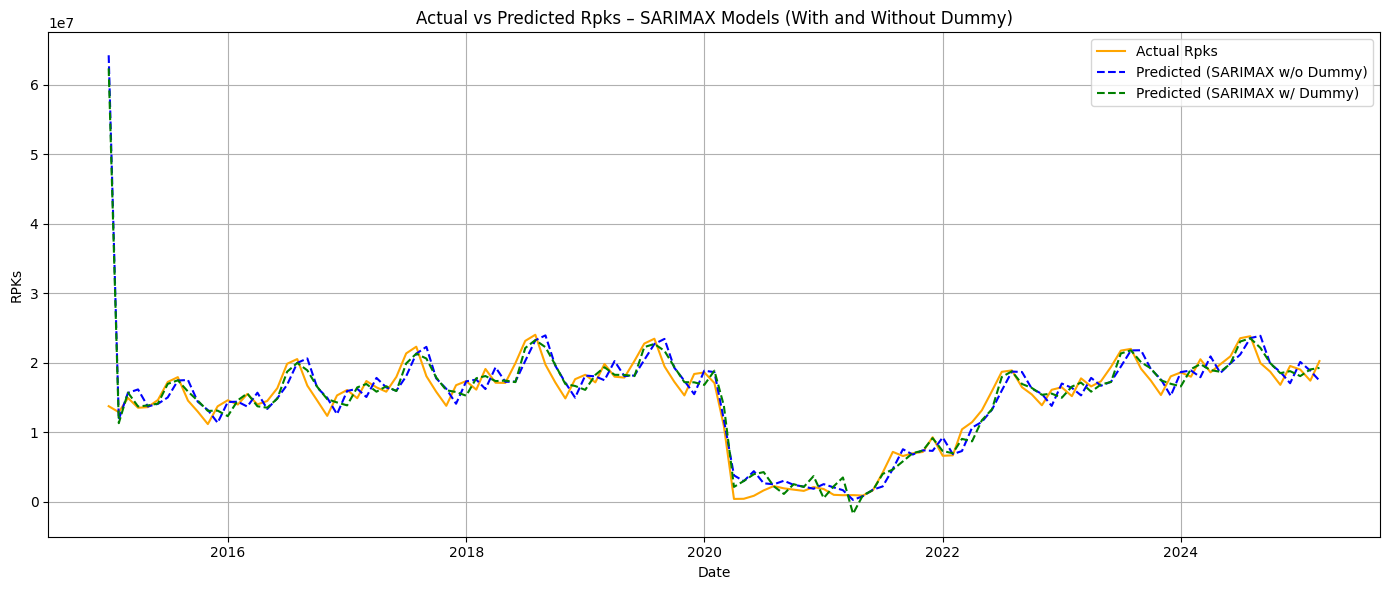

In [ ]:
# Generate predictions from both SARIMAX models
df['Predicted_SARIMAX_Base'] = sarimax_base_result.fittedvalues
df['Predicted_SARIMAX_Full'] = sarimax_full_result.fittedvalues

# Plot actual vs predicted values for both models
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Rpks'], label='Actual Rpks', color='orange')
plt.plot(df.index, df['Predicted_SARIMAX_Base'], label='Predicted (SARIMAX w/o Dummy)', linestyle='--', color='blue')
plt.plot(df.index, df['Predicted_SARIMAX_Full'], label='Predicted (SARIMAX w/ Dummy)', linestyle='--', color='green')

plt.title("Actual vs Predicted Rpks – SARIMAX Models (With and Without Dummy)")
plt.xlabel("Date")
plt.ylabel("RPKs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()